<a href="https://colab.research.google.com/github/draxssup/Stonks/blob/main/Stock_Prediction_with_higher_acc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Fetch stock data
def fetch_stock_data(ticker, start_date, end_date):
    print(f"Fetching data for {ticker} from {start_date} to {end_date}...")
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Example: Fetch Apple stock data
ticker = input("Enter the stock ticker symbol (e.g., AAPL): ")
start_date = input("Enter the start date (YYYY-MM-DD): ")
end_date = input("Enter the end date (YYYY-MM-DD): ")
data = fetch_stock_data(ticker, start_date, end_date)


Enter the stock ticker symbol (e.g., AAPL): DOOO
Enter the start date (YYYY-MM-DD): 2020-01-01
Enter the end date (YYYY-MM-DD): 2020-09-10


[*********************100%***********************]  1 of 1 completed

Fetching data for DOOO from 2020-01-01 to 2020-09-10...


In [55]:
def clean_and_engineer_data(data):
    data.fillna(method='ffill', inplace=True)
    scaler = MinMaxScaler()
    data['Close_scaled'] = scaler.fit_transform(data[['Close']])
    data['Target'] = (data['Close'].shift(-1) > data['Close']).astype(int)
    data['5_day_MA'] = data['Close'].rolling(window=5).mean()
    data['10_day_MA'] = data['Close'].rolling(window=10).mean()
    data['5_day_EMA'] = data['Close'].ewm(span=5, adjust=False).mean()
    data['10_day_EMA'] = data['Close'].ewm(span=10, adjust=False).mean()

    def calculate_rsi(data, window=14):
        delta = data['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        RS = gain / loss
        RSI = 100 - (100 / (1 + RS))
        return RSI

    data['RSI'] = calculate_rsi(data)
    data['20_day_MA'] = data['Close'].rolling(window=20).mean()
    data['20_day_SD'] = data['Close'].rolling(window=20).std()
    data['Upper_BB'] = data['20_day_MA'] + (data['20_day_SD'] * 2)
    data['Lower_BB'] = data['20_day_MA'] - (data['20_day_SD'] * 2)
    data['OBV'] = (data['Volume'].where(data['Close'] > data['Close'].shift(1), -data['Volume'])).cumsum()
    data['Volatility'] = data['Close'].rolling(window=10).std()
    data.dropna(inplace=True)
    return data

data = clean_and_engineer_data(data)


<ipython-input-55-b0a993eb380f>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [56]:
def split_and_balance_data(data):
    X = data[['Close_scaled', '5_day_MA', '10_day_MA', '5_day_EMA', '10_day_EMA', 'RSI', 'Volatility', 'OBV']]
    y = data['Target']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Balance the dataset
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    return X_train_balanced, X_test, y_train_balanced, y_test

X_train_balanced, X_test, y_train_balanced, y_test = split_and_balance_data(data)


Model Performance:
              precision    recall  f1-score   support

           0       0.72      0.76      0.74        17
           1       0.69      0.64      0.67        14

    accuracy                           0.71        31
   macro avg       0.71      0.70      0.70        31
weighted avg       0.71      0.71      0.71        31

Accuracy: 0.71


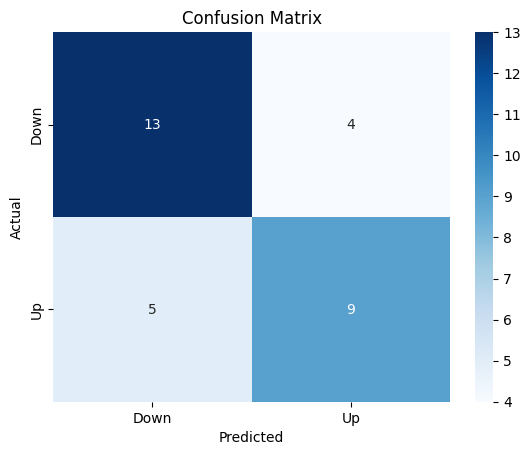

In [57]:
def train_and_evaluate_model(X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print("Model Performance:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

    # Plot confusion matrix
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

train_and_evaluate_model(X_train_balanced, y_train_balanced, X_test, y_test)
